# Set up the connection to MongoDB

In [1]:
import nltk
import requests
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pymongo import MongoClient
from mongohandler import *
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from bson.son import SON
from src.config import *

# IMPORTANT : Remember to start mongodb server
# run $ sudo systemctl start mongod
# Also, start the api.py Flask server
#     $ python3 api.py

Connected to MongoClient at: mongodb://localhost:27017


In [2]:
client = MongoClient(DBURL)
db = client.messenger
print(f"Connected to MongoClient at: {DBURL}")
nltk.download('vader_lexicon')

Connected to MongoClient at: mongodb://localhost:27017


[nltk_data] Downloading package vader_lexicon to /home/rh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Trying out our basic functions

To interact with the Messenger API we will use the python built-in `requests` module.

These aditionally, we will leverage on MongoDB as a database to store all relevant data for the `users` `chats` and `messages`. To do this, a `mongohandler` module with functions has also been developed and imported.

### To begin, lets use some scripts from the TV Show `Rick and Morty` to seed out API.

In [3]:
df = pd.read_csv('INPUT/RickAndMortyScripts.csv')
df.head(3)

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."


### 1 - Create Users:
Endpoint: `/user/create/<username>`

In [4]:
usernames = [e for e in df.name.value_counts().index]
print(usernames[:8])

['Rick', 'Morty', 'Beth', 'Jerry', 'Summer', 'Pickle Rick', 'Supernova', 'Cop Morty']


In [5]:
def import_usernames(usernames):
    for user in usernames:
        route = f'/user/create/{user}'
        res = requests.get(flask_api+route)
    #returns only the last response
    return res

last_response = import_usernames(usernames)
print(f'We have tried to create {len(usernames)} users.')
print("Last recorded event : ")    
display(HTML(last_response.text)) # Last user created    

We have tried to create 48 users.
Last recorded event : 


### 2 - Create Public Chats
To do this, we will group the df by episode name, and use that variable as the `chat_title` to send to the API. Also, this group by allows us to see a list of the characters present on each episode.

Use this as an index to later create the group with the right members


In [6]:
chats_outline = df.groupby(['episode name', 'name']).agg({'line':'count'})
display(chats_outline.head(6))

line
episode name     name             
A Rickle in Time All Mortys     15
                 All Ricks      32
                 All Summers    13
                 Beth           30
                 Jerry          25
                 Morty          24

Also, create a list of all the episodes we are going to upload

In [7]:
all_chat_titles = df['episode name'].drop_duplicates().values
all_chat_titles

array(['Pilot', 'Lawnmower Dog', 'Rick Potion 9', 'A Rickle in Time',
       'The Wedding Squanchers', 'Get Schwifty',
       'Interdimensional Cable 2  Tempting Fate',
       'The Rickshank Rickdemption', 'Pickle Rick',
       'Vindicators 3  The Return of Worldender',
       'Tales From the Citadel'], dtype=object)

#### Sending a request to the API, for every available `chat_tile & usernames` group

In [8]:
def create_chat(chat_title, participants):
    route = f"/chat/create?title={chat_title}&users={participants}"
    res = requests.get(flask_api+route)
    return res

In [9]:
for chat_title in all_chat_titles:
    participants = list(chats_outline.loc[chat_title].index) # These are the chat_titles and usernames
    res = create_chat(chat_title, participants)

    
print("Last recorded event's http response: ")    
display(HTML(res.text))

Last recorded event's http response: 


### 3 - Add New Users to an existing chat
To do this, I have create a new dummy user `rihp`, and added it to the `get_schwifty` chat.

In [10]:
def add_user_to_chat(username, chat_title):
    route = f"/chat/{chat_title}/adduser?&username={username}"
    res = requests.get(flask_api+route)
    return res

In [11]:
username=['rihp']
chat_title = "get_schwifty"

res = import_usernames(username)
display(HTML(res.text))
print('------------------------------------------------------')
res = add_user_to_chat(*username, chat_title)
display(HTML(res.text))

------------------------------------------------------


username='rihp'
chat_title = "get_schwifty"

import_usernames(['rihp'])
res = requests.get(flask_api+f'/user/create/{username}')
display(HTML(res.text))
print('------------------------------------------------------')
route = f"/chat/{chat_title}/adduser?&username={username}"
res = requests.get(flask_api+route)
display(HTML(res.text))

### 4 - Add Messages to a public chat
Using our dataset, we will use the following columns to populate our collection of `messages`

#### To send a message, the user must be part of the chat
This function is buggy and prints a lot of verbose.
Please fix 

`check_user_in_chat('rihp', 'pickle_rick')`

In [12]:
m_outline = df[['episode name', 'name', 'line']]
m_outline.head(3)

,episode name,name,line
0,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,Pilot,Morty,"What, Rick? What’s going on?"
2,Pilot,Rick,"I got a surprise for you, Morty."


m_outline[m_outline['episode name'] == 'Pickle Rick'].tail(3)

### The execution of these cells is not very efficient
they send all the messages to the database

In [13]:
def send_message(username, chat_title, text):
    route = f"/chat/{chat_title}/addmessage?username={username}&text={text}"
    res = requests.get(flask_api+route)
    return res

In [14]:
for i in m_outline.index:
    message = m_outline.iloc[i]                         # Locate the message
    chat_title = message['episode name']                # Define the episode name
    username = message['name']                          # Define the username  
    text = message['line']                              # Define the message text
    res  = send_message(username, chat_title, text)# <----SEND MESSAGE TO API------
print("Last recorded event (The http response): ")    
display(HTML(res.text))

Last recorded event (The http response): 


### 5 - Query all the messages sent to an specific chat
- (GET) `/chat/<chat_id>/list`

Aggregate the messages in the chat, using this pipeline query on our Mongo Database

In [15]:
cur = db.chat.aggregate([{'$lookup': {
                            'from': 'messages',             # Use the messages collection
                            'localField': 'messages',   
                            'foreignField': '_id',     
                            'as': 'messages'}
                        }, 
                         {'$project': {
                            '_id': 1, 
                            'title': 1, 
                            'participants': 1, 
                            'messages': {
                                'text': 1, 
                                'username': 1}
                        }}])
query = list(cur)

### Access the specific chat and display some of the messages
This is not the specific chat, its only the first one in the list. fix this

In [16]:
all_chat_titles = list(enumerate([doc['title'] for doc in query]))
all_chat_titles

[(0, 'pilot'),
 (1, 'lawnmower_dog'),
 (2, 'rick_potion_9'),
 (3, 'a_rickle_in_time'),
 (4, 'the_wedding_squanchers'),
 (5, 'get_schwifty'),
 (6, 'interdimensional_cable_2__tempting_fate'),
 (7, 'the_rickshank_rickdemption'),
 (8, 'pickle_rick'),
 (9, 'vindicators_3__the_return_of_worldender'),
 (10, 'tales_from_the_citadel')]

### Access the first 5 lines of the `Pickle Rick` episode, index `8`

In [17]:
for i in range(5):
    print(query[8]['messages'][i]['text']) 

Morty.
Rick?
Morty!
Rick?
Hey, Mooorty!


### 6 - Perform a Sentiment analysis on an specific chat message history
- (GET) `/chat/<chat_id>/sentiment`

In this case, we will start analyzing Rick and Morty's (Season 1, Episode 5), `Get Schwifty`.

In [18]:
# This function takes in a pymongo query cursor
# which has already been turned into a list
# and looks for an specific chat title.

def get_chat_doc(chat_title, query):
    for i in range(len(query)):
        if query[i]['title'] == chat_title:
            yield query[i]

#### Set the chat_title variable

In [19]:
episode = 'Get Schwifty'
chat_title = no_spaces(episode).lower()
chat_messages = list(get_chat_doc(chat_title, query))[0]['messages']

if len(chat_messages) != df['episode name'].value_counts()[episode]: 
    raise Exception('something is wrong here, the database has more messages than it should have')

#### Begin the sentiment analysis of that chat room

In [20]:
sia = SentimentIntensityAnalyzer()

In [21]:
def analyze_chat_sentiment(chat_messages):
    for i in range(len(chat_messages)):
        text = chat_messages[i]['text']
        yield sia.polarity_scores(text) # Analyze this

In [22]:
print(f"Sentiment analysis for the chat: \n {chat_title}")
sentiment = pd.DataFrame(list(analyze_chat_sentiment(chat_messages)))
display(sentiment.describe())

Sentiment analysis for the chat: 
 get_schwifty


,neg,neu,pos,compound
count,221.000000,221.000000,221.000000,221.000000
mean,0.104633,0.780190,0.115186,0.046848
std,0.200661,0.239887,0.187185,0.433142
min,0.000000,0.000000,0.000000,-0.891000
25%,0.000000,0.647000,0.000000,-0.102700
50%,0.000000,0.809000,0.000000,0.000000
75%,0.133000,1.000000,0.191000,0.361200
max,1.000000,1.000000,1.000000,0.978500


#### Get the mean compound for all the chats

In [23]:
def get_chats_sia_scores(all_chat_titles):
    overall_scores = {}
    for episode_num, chat_title in all_chat_titles:
        chat_messages = list(get_chat_doc(chat_title, query))[0]['messages']
        sentiment = pd.DataFrame(list(analyze_chat_sentiment(chat_messages)))
        overall_scores.update({chat_title:sentiment.describe().loc['mean']['compound']})
    return pd.DataFrame.from_dict(overall_scores, orient='index', columns=['mean_compound_score'])

<BarContainer object of 11 artists>

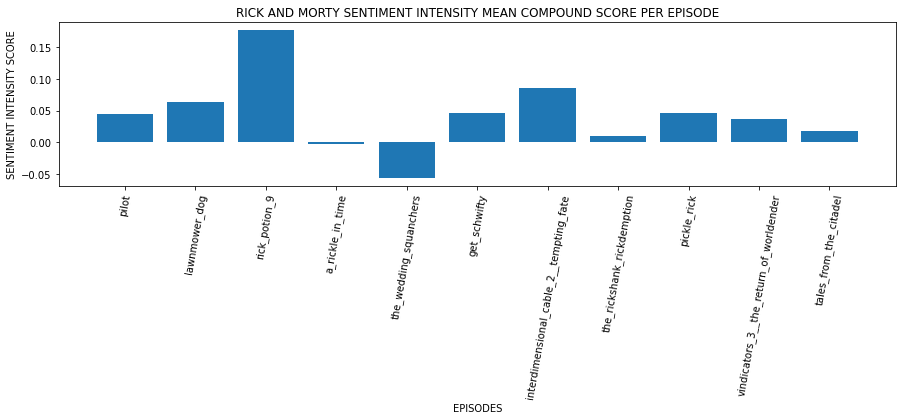

In [24]:
all_chats_sia_scores = get_chats_sia_scores(all_chat_titles)
plt.figure(figsize=(15,3))
plt.xticks(rotation=80)
plt.xlabel('EPISODES')
plt.ylabel('SENTIMENT INTENSITY SCORE')
plt.title('RICK AND MORTY SENTIMENT INTENSITY MEAN COMPOUND SCORE PER EPISODE')
plt.bar(all_chats_sia_scores.index,all_chats_sia_scores.mean_compound_score )

### 7 - Query all the messages sent from an specific user

In [25]:
cur = db.user.aggregate([{'$lookup': {
                                'from': 'messages',             
                                'localField': 'messages_sent', 
                                'foreignField': '_id', 
                                'as': 'all_messages'}
                        },
                         {'$project': {
                                'username': 1,
                                'all_messages': {
                                    'text': 1}}}])
query = list(cur)

Use a query, find a username and create an iterator that includes all the messages from that username

In [26]:
def iter_messages_from_user(query, username):
    for user_doc in query:                               # Exploring the query
        if user_doc['_id'] == get_user_id(username):     # Finding an specific user id   
            for message in user_doc['all_messages']:     # Looping through the messages
                yield message['text']                    # Analyze these raw strings

In [37]:
username = 'Morty'

In [38]:
all_user_messages = list(iter_messages_from_user(query, username))   # As an array of strings
all_user_messages[:2]

['What, Rick? What’s going on?',
 "It's the middle of the night. What are you talking about?"]

Take an array of strings and create an iterator of SIA scores

In [39]:
def iter_sia_scores(array_of_strings):
    for i in range(len(array_of_strings)):
        text = array_of_strings[i]            # Define the raw string to be analyzed
        yield sia.polarity_scores(text)       # Yield the results of the Polarity Score for each message

In [40]:
user_scores = list(iter_sia_scores(all_user_messages))
user_scores[:2]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

#### Pass a list of sia scores, and return a pandas dataframe

In [50]:
print(f"Describing sentiment intensity for user:\n {username}") 
to_df = lambda x : pd.DataFrame(x)
to_df(user_scores).describe()

Describing sentiment intensity for user:
 Morty


,neg,neu,pos,compound
count,347.000000,347.000000,347.000000,347.000000
mean,0.089723,0.793602,0.116657,0.029093
std,0.176656,0.248450,0.202260,0.379501
min,0.000000,0.000000,0.000000,-0.910800
25%,0.000000,0.645500,0.000000,0.000000
50%,0.000000,0.861000,0.000000,0.000000
75%,0.100500,1.000000,0.191500,0.273200
max,0.851000,1.000000,1.000000,0.955600


### 8 - Recommender system takes in an `user_id` and return top-3 similar `users`
- (GET) `/user/<user_id>/recommend`

### 9 - Move local database to MongoAtlas cloud

### 10 - Prepare Docker Image

### 11  - Deploy Docker Image in Heroku

In [ ]:
# Some basic checking:
Is there a chat 